<a href="https://colab.research.google.com/github/faezesarlakifar/RecommenderSystem/blob/main/RecommenderSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

# Accessing My Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Necessaries

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn import preprocessing

from sklearn.metrics.pairwise import cosine_similarity

# use this for PCA
from sklearn.decomposition import TruncatedSVD

# used for collaborative model
from sklearn.model_selection import train_test_split

# Import Data

In [ ]:
movies  = pd.read_csv('/content/drive/MyDrive/ML/Dataset/movies_metadata.csv')
credits = pd.read_csv('/content/drive/MyDrive/ML/Dataset/credits.csv')
keywords = pd.read_csv('/content/drive/MyDrive/ML/Dataset/keywords.csv')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


# Preprocess Data

## Remove Unimportant Features

In [ ]:
movies.drop(["homepage", "imdb_id", "poster_path"], axis='columns', inplace=True)

## Merge Data and Handle Some String Issues

In [ ]:
movies['id']   = movies['id'].astype(str)
credits['id']  = credits['id'].astype(str)
keywords['id'] = keywords['id'].astype(str)

movies1 = pd.merge(movies, credits, on='id')
movies1 = pd.merge(movies1, keywords, on='id')
movies1['id']   = movies1['id'].astype('int')

In [ ]:
features = ['cast', 'crew', 'keywords', 'genres', 'director']
for feature in features:
    if feature == 'director':
      continue
    movies1[feature] = movies1[feature].apply(eval)

In [ ]:
def get_director_name(x):
  names = []
  if isinstance(x, list):
    names = [i['name'] for i in x]
    jobs = [i['job'] for i in x]
    try:
      index = jobs.index('Director')
      return names[index]
    except ValueError:
      return np.nan
  
  return names

In [ ]:
movies1['director'] = movies1['crew'].apply(get_director_name)

### We Want to Predict the most similar movies by using 3 best similar keyword and genre and cast.

In [ ]:
def get_list(x):
  names = []
  if isinstance(x, list):
    names = [i['name'] for i in x]
    if len(names) > 3:
      names = names[:3] #first three elements
      return names

  return names

In [ ]:
features = ['cast', 'keywords', 'genres']
for feature in features:
    movies1[feature] = movies1[feature].apply(get_list)

## Let's See Our Data Now

In [ ]:
df = movies1

df[['title', 'cast', 'director', 'keywords', 'genres']].head() 

,title,cast,director,keywords,genres
0,Toy Story,"[Tom Hanks, Tim Allen, Don Rickles]",John Lasseter,"[jealousy, toy, boy]","[Animation, Comedy, Family]"
1,Jumanji,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]",Joe Johnston,"[board game, disappearance, based on children'...","[Adventure, Fantasy, Family]"
2,Grumpier Old Men,"[Walter Matthau, Jack Lemmon, Ann-Margret]",Howard Deutch,"[fishing, best friend, duringcreditsstinger]","[Romance, Comedy]"
3,Waiting to Exhale,"[Whitney Houston, Angela Bassett, Loretta Devine]",Forest Whitaker,"[based on novel, interracial relationship, sin...","[Comedy, Drama, Romance]"
4,Father of the Bride Part II,"[Steve Martin, Diane Keaton, Martin Short]",Charles Shyer,"[baby, midlife crisis, confidence]",[Comedy]


## Check Adult Feature Distribution

(0.0, 2.0, 0.9, 1.2)

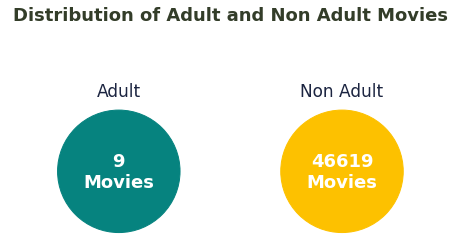

In [ ]:
plt.figure(figsize=(8,4))
plt.scatter(x=[0.5, 1.5], y=[1,1], s=15000, color=['#06837f', '#fdc100'])
plt.xlim(0,2)
plt.ylim(0.9,1.2)

plt.title('Distribution of Adult and Non Adult Movies', fontsize=18, weight=600, color='#333d29')
plt.text(0.5, 1, '{}\nMovies'.format(str(len(df[df['adult']=='True']))), va='center', ha='center', fontsize=18, weight=600, color='white')
plt.text(1.5, 1, '{}\nMovies'.format(str(len(df[df['adult']=='False']))), va='center', ha='center', fontsize=18, weight=600, color='white')
plt.text(0.5, 1.11, 'Adult', va='center', ha='center', fontsize=17, weight=500, color='#1c2541')
plt.text(1.5, 1.11, 'Non Adult', va='center', ha='center', fontsize=17, weight=500, color='#1c2541')

plt.axis('off')

most of the movies are non adult movie...

## Clean The Data

- remove spaces.

- make all chars lowercase.

In [ ]:
def cleaning_data(x):
  result = ''
  if isinstance(x, list):
    result = [str.lower(i.replace(' ', '')) for i in x]
  else:
    if isinstance(x, str): #director 
      result = str.lower(x.replace(' ', ''))

  return result

In [ ]:
for feature in features:
    movies1[feature] = movies1[feature].apply(cleaning_data)

In [ ]:
df1 = df

In [ ]:
df.dropna(subset=['tagline'], axis='rows', inplace=True)

In [ ]:
df.dropna(inplace=True)

## Use PCA for Dimentionaly Reduction to avoid RAM Crashing

In [ ]:
# Initialize a tfidf object
tfidf = TfidfVectorizer(max_features=3000)

# Transform the data
vectorized_data = tfidf.fit_transform(df['tagline'].values)



In [ ]:
vectorized_dataframe = pd.DataFrame(vectorized_data.toarray(), index=df['tagline'].index.tolist())

In [ ]:
# Initialize a PCA object
svd = TruncatedSVD(n_components=25)

# Fit transform the data
reduced_data = svd.fit_transform(vectorized_dataframe)

# Print the shape
reduced_data.shape



(2598, 25)

## Let's See Cleaned Dataset Details

In [ ]:
df.head() 

,adult,belongs_to_collection,budget,genres,id,original_language,original_title,overview,popularity,production_companies,...,status,tagline,title,video,vote_average,vote_count,cast,crew,keywords,director
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[romance, comedy]",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",...,Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[waltermatthau, jacklemmon, ann-margret]","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[fishing, bestfriend, duringcreditsstinger]",Howard Deutch
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[comedy],11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...",...,Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[stevemartin, dianekeaton, martinshort]","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[baby, midlifecrisis, confidence]",Charles Shyer
9,False,"{'id': 645, 'name': 'James Bond Collection', '...",58000000,"[adventure, action, thriller]",710,en,GoldenEye,James Bond must unmask the mysterious head of ...,14.686036,"[{'name': 'United Artists', 'id': 60}, {'name'...",...,Released,No limits. No fears. No substitutes.,GoldenEye,False,6.6,1194.0,"[piercebrosnan, seanbean, izabellascorupco]","[{'credit_id': '52fe426ec3a36847f801e14b', 'de...","[cuba, falselyaccused, secretidentity]",Martin Campbell
12,False,"{'id': 117693, 'name': 'Balto Collection', 'po...",0,"[family, animation, adventure]",21032,en,Balto,An outcast half-wolf risks his life to prevent...,12.140733,"[{'name': 'Universal Pictures', 'id': 33}, {'n...",...,Released,Part Dog. Part Wolf. All Hero.,Balto,False,7.1,423.0,"[kevinbacon, bobhoskins, bridgetfonda]","[{'credit_id': '593f24b9c3a3680369002371', 'de...","[wolf, dog-sleddingrace, alaska]",Simon Wells
18,False,"{'id': 3167, 'name': 'Ace Ventura Collection',...",30000000,"[crime, comedy, adventure]",9273,en,Ace Ventura: When Nature Calls,"Summoned from an ashram in Tibet, Ace finds hi...",8.205448,"[{'name': 'O Entertainment', 'id': 5682}, {'na...",...,Released,New animals. New adventures. Same hair.,Ace Ventura: When Nature Calls,False,6.1,1128.0,"[jimcarrey, ianmcneice, simoncallow]","[{'credit_id': '52fe44dfc3a36847f80af28b', 'de...","[africa, indigenous, humananimalrelationship]",Steve Oedekerk


In [ ]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2598 entries, 2 to 46520
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  2598 non-null   object 
 1   belongs_to_collection  2598 non-null   object 
 2   budget                 2598 non-null   object 
 3   genres                 2598 non-null   object 
 4   id                     2598 non-null   int64  
 5   original_language      2598 non-null   object 
 6   original_title         2598 non-null   object 
 7   overview               2598 non-null   object 
 8   popularity             2598 non-null   object 
 9   production_companies   2598 non-null   object 
 10  production_countries   2598 non-null   object 
 11  release_date           2598 non-null   object 
 12  revenue                2598 non-null   float64
 13  runtime                2598 non-null   float64
 14  spoken_languages       2598 non-null   object 
 15  sta

In [ ]:
df['release_date'] = pd.to_datetime(df['release_date'])
df['budget'] = df['budget'].astype('float64')
df['popularity'] = df['popularity'].astype('float64') 

## Data Visualization

### Analyse The Adult Feature Again After Cleaning Data

#### Use Visualization to check the distribution of adult feature in our records

(0.0, 2.0, 0.9, 1.2)

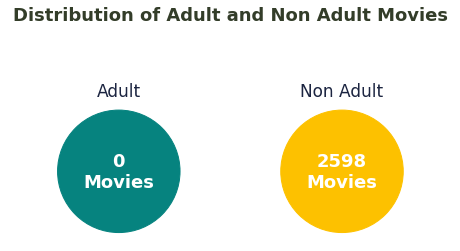

In [ ]:
plt.figure(figsize=(8,4))
plt.scatter(x=[0.5, 1.5], y=[1,1], s=15000, color=['#06837f', '#fdc100'])
plt.xlim(0,2)
plt.ylim(0.9,1.2)

plt.title('Distribution of Adult and Non Adult Movies', fontsize=18, weight=600, color='#333d29')
plt.text(0.5, 1, '{}\nMovies'.format(str(len(df[df['adult']=='True']))), va='center', ha='center', fontsize=18, weight=600, color='white')
plt.text(1.5, 1, '{}\nMovies'.format(str(len(df[df['adult']=='False']))), va='center', ha='center', fontsize=18, weight=600, color='white')
plt.text(0.5, 1.11, 'Adult', va='center', ha='center', fontsize=17, weight=500, color='#1c2541')
plt.text(1.5, 1.11, 'Non Adult', va='center', ha='center', fontsize=17, weight=500, color='#1c2541')

plt.axis('off')

##### because all of the movies are non adult now (their adult feature is false), we can remove this useless feature. 

In [ ]:
df.drop(['adult'], axis='columns', inplace=True) 

### Visualize The Average Rating of Movies

In [ ]:
rich1=df.sort_values('vote_average',ascending=False)
rich1.head()


,belongs_to_collection,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,...,status,tagline,title,video,vote_average,vote_count,cast,crew,keywords,director
39046,"{'id': 415931, 'name': 'The Bowery Boys', 'pos...",0.0,[comedy],185273,en,Bowery Battalion,"Slip, Sach and the gang (Bowery Boys) think an...",0.462816,"[{'name': 'Monogram Pictures', 'id': 4395}]","[{'iso_3166_1': 'US', 'name': 'United States o...",...,Released,THEY'RE THE DAFFIEST DRAFTEES IN HISTORY!,Bowery Battalion,False,10.0,1.0,"[leogorcey, huntzhall, donaldmacbride]","[{'credit_id': '52fe4cdb9251416c75127ccf', 'de...","[army, boweryboys]",William Beaudine
44517,"{'id': 288882, 'name': 'Bloodfight', 'poster_p...",0.0,[action],41289,en,Bloodfight,Master martial artist Masahiro Kai is a shadow...,0.255977,"[{'name': 'Kurata Film Company', 'id': 31030}]","[{'iso_3166_1': 'HK', 'name': 'Hong Kong'}]",...,Released,Beneath the fight. Beyond the fight. Become th...,Bloodfight,False,9.0,1.0,"[yasuakikurata, simonyam, meglamkin-ming]","[{'credit_id': '52fe45c1c3a36847f80d8907', 'de...",[],Shuji Goto
41229,"{'id': 478244, 'name': ""Spirits' Homecoming Co...",0.0,"[drama, history]",384641,ko,귀향,"Two Korean girls, Jung-Min (14) and Young-hee ...",1.264456,"[{'name': 'JO Entertainment', 'id': 73661}]","[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",...,Released,"Trampled souls, seeking their way home, finall...",Spirits' Homecoming,False,8.5,5.0,"[kangha-na, choiri, seomi-ji]","[{'credit_id': '5740d3929251416597000a20', 'de...","[worldwarii, koreanmovie, 'comfortwomen']",Cho Jung-rae
8613,"{'id': 85473, 'name': 'The Human Condition', '...",0.0,"[war, drama, history]",34528,ja,人間の條件 第３部望郷篇／第４部戦雲篇,"Kaji, having lost his exemption from military ...",1.914775,"[{'name': 'Shôchiku Eiga', 'id': 5070}]","[{'iso_3166_1': 'JP', 'name': 'Japan'}]",...,Released,First Sequel of an Anti-War Masterpiece,The Human Condition II: Road to Eternity,False,8.5,31.0,"[tatsuyanakadai, michiyoaratama, kokinjikatsura]","[{'credit_id': '52fe45699251416c910315bb', 'de...","[japan, japanese, worldwarii]",Masaki Kobayashi
41547,"{'id': 201932, 'name': 'The Nigger Charley Col...",0.0,"[western, action, crime]",87788,en,The Legend of Nigger Charley,A trio of runaway slaves evade authorities in ...,0.129052,"[{'name': 'Paramount Pictures', 'id': 4}]","[{'iso_3166_1': 'US', 'name': 'United States o...",...,Released,Somebody warn the West. Nigger Charley ain't r...,The Legend of Nigger Charley,False,8.5,2.0,"[fredwilliamson, d'urvillemartin, donpedrocolley]","[{'credit_id': '57c3db3fc3a3680864001950', 'de...","[slavery, blaxploitation]",Martin G. Goldman


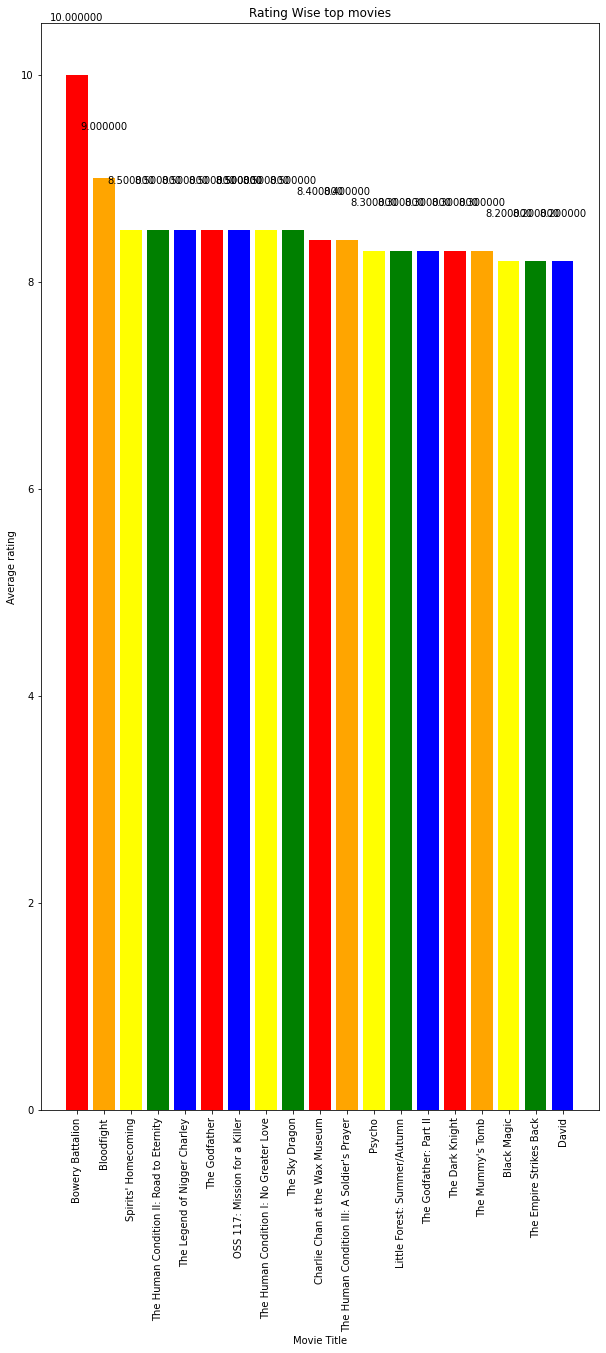

In [ ]:
fig, ax = plt.subplots()
rects1 = ax.bar(rich1['title'].head(20),rich1['vote_average'].head(20), color=["Red","Orange","Yellow","Green","Blue"])
plt.xlabel("Movie Title")
plt.rcParams["figure.figsize"] = (10,20)
plt.title("Rating Wise top movies")
plt.ylabel("Average rating")

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%f' % float(height),
        ha='center', va='bottom')
autolabel(rects1)
plt.xticks(rotation=90)

plt.show()

### Visualize Keywords

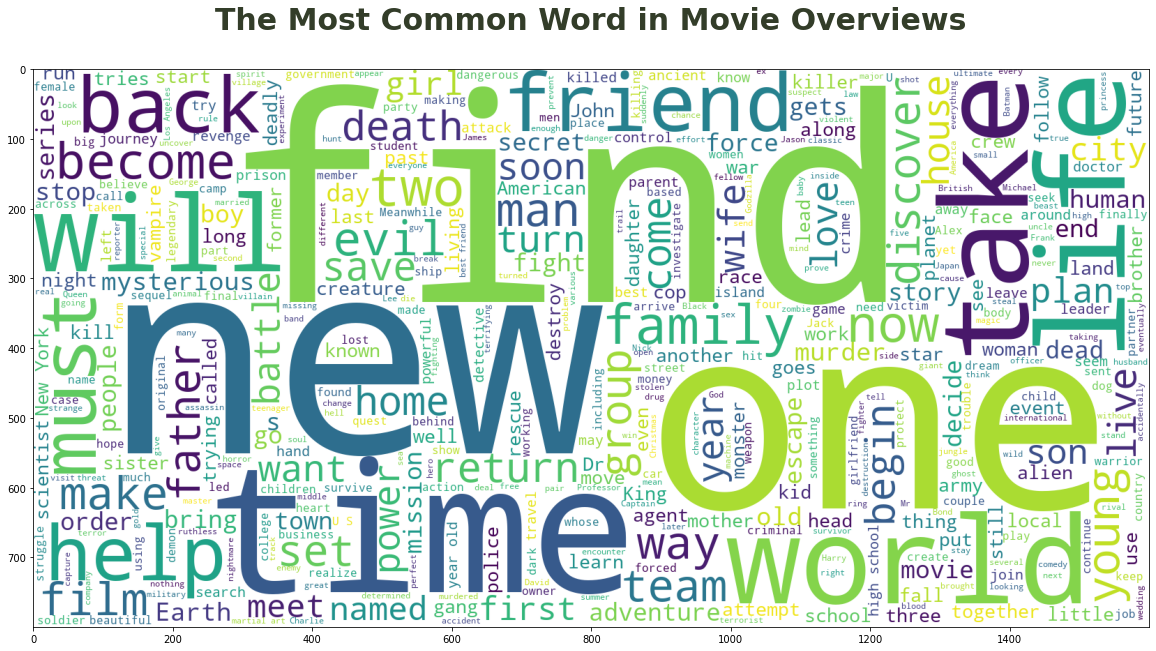

In [ ]:
from wordcloud import WordCloud 
plt.figure(figsize=(20,20))
plt.title('The Most Common Word in Movie Overviews\n', fontsize=30, weight=600, color='#333d29')
wc = WordCloud(max_words=1000, min_font_size=10,
                height=800,width=1600,background_color="white").generate(' '.join(df['overview']))

plt.imshow(wc)

# Content Based Filtering

## Concat Features

In [ ]:
def concat_features(x):
  result = ' '.join(x['cast']) + ' ' +  x['director'] + ' ' + ' '.join(x['keywords']) + ' ' + ' '.join(x['genres'])
  return result 

In [ ]:
movies1['metadata'] = movies1.apply(concat_features, axis=1)
metadata = movies1['metadata']

In [ ]:
movies1.drop(['crew', 'cast', 'keywords', 'director'], axis='columns', inplace=True) 

In [ ]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(metadata)
cosine_sim = cosine_similarity(count_matrix, count_matrix) 

In [ ]:
movies1 = movies1.reset_index() 
indices = pd.Series(movies1.index, index=movies1['title']) 

## Similar Recommend

In [ ]:
def similar_recommendations(dataset, title, cosine_sim, n):

    if(dataset[dataset['title'].isin([title])].empty):
      return []

    idx = indices[title] 
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n+1]
    movie_indices = [i[0] for i in sim_scores]
    #return dataset['title'].iloc[movie_indices]
    return dataset.iloc[movie_indices]

In [ ]:
res = similar_recommendations(movies1, 'The Godfather', cosine_sim, 10) 
res.title

270             The Godfather: Part III
134              The Godfather: Part II
1395               Lost Boys: The Tribe
1555    Wall Street: Money Never Sleeps
1858          Mr. Moto in Danger Island
2134                           Sweeney!
2510                Maigret Sets a Trap
973                Song of the Thin Man
1259                         Election 2
1444                        Black Magic
Name: title, dtype: object

In [ ]:
df_content_based = df

## Combine All Content Based operations on a Single function for using in Hybride model

set m as a hyper parameter

In [ ]:
m = 5

In [ ]:
ratings = pd.read_csv('/content/drive/MyDrive/ML/Dataset/ratings_small.csv')

In [ ]:
def EnsembledCbRec(ratings, movies_, n, m, userID):

  # Find Rated Movies by this user
  rated_movies = list(ratings[ratings.userId == userID].movieId)

  rated_movies_str = [str(x) for x in rated_movies]

  rated_movies_in_movie_metadata = movies[movies['id'].isin(rated_movies_str)]

  rated_movies_ids = rated_movies_in_movie_metadata.id

  rated_movies_ids_int = [int(x) for x in rated_movies_ids]

  # Find top m movies rated by this user
  if (m > len(rated_movies)):
    m = len(rated_movies) // 2

  rated_movies = ratings[ratings['movieId'].isin(rated_movies_ids_int)]

  top_rated_movies = rated_movies.sort_values('rating').head(m).movieId

  # Find n top simillar movies by content based filtering for each m movie
  top_rated_movies_str = [str(x) for x in top_rated_movies]

  top_rated_movies_in_movie_metadata = movies[movies['id'].isin(top_rated_movies_str)]

  top_movies = []
  for i, top_rated_movie in top_rated_movies_in_movie_metadata.iterrows():

    simillar_movies = similar_recommendations(movies_, top_rated_movie.title, cosine_sim, n)

    if(len(simillar_movies)!=0):
      simillar_ids = list(simillar_movies.id)
      top_movies.extend(simillar_ids)

  # Now we have n * m top movies can be recommend to user
  return top_movies 


# Colaborative Fitering

### Set the id of user whome we want to recommend.

In [ ]:
user_id = 1

### Let's See the Most Popular Movies Between Users

Text(0.5, 1.0, 'Popular Movies')

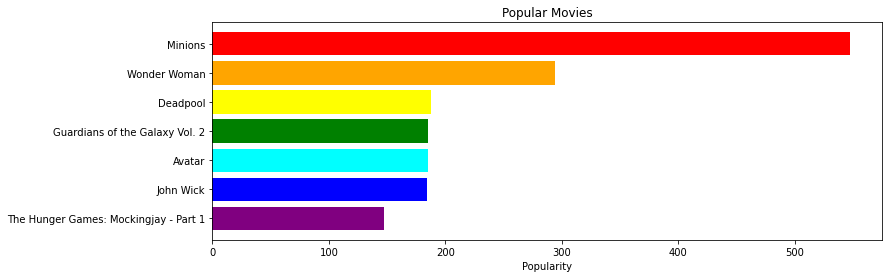

In [ ]:
pop= df.sort_values('popularity', ascending=False)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

plt.barh(pop['title'].head(7),pop['popularity'].head(7), align='center',
        color=['red','orange','yellow','green', 'cyan', 'blue', 'purple'])
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

### Import Users Ratings and movies

- now we need users ratings in this model. because prediction is based on similarity of users and movies together.

In [ ]:
ratings = pd.read_csv("/content/drive/MyDrive/ML/Dataset/ratings_small.csv")

df = ratings
movies = pd.read_csv('/content/drive/MyDrive/ML/Dataset/movies_metadata.csv')

ratings.head()

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
print('Number of missing values in rating column: {}'.format(ratings['rating'].isna().sum())) 

Number of missing values in rating column: 0


In [ ]:
ratings.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [ ]:
ratings.shape

(100004, 4)

In [ ]:
ratings.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


##Model Based Approach

### Define Model & Train
- Using Tensorflow and a DeepLearning Model

#### Import Necessaries for building Tensorflow Model

###### install tensorflow.keras

In [ ]:
!pip install tensorflow.keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement tensorflow.keras (from versions: none)
ERROR: No matching distribution found for tensorflow.keras


###### import

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 

#### Let's see the preview of what we want to make Embedding vector from
- top ratings

In [ ]:
def tabular_preview(ratings, n=15):

    user_groups = ratings.groupby('userId')['rating'].count()
    top_users = user_groups.sort_values(ascending=False)[:15]

    movie_groups = ratings.groupby('movieId')['rating'].count()
    top_movies = movie_groups.sort_values(ascending=False)[:15]

    top = (
        ratings.
        join(top_users, rsuffix='_r', how='inner', on='userId').
        join(top_movies, rsuffix='_r', how='inner', on='movieId'))

    return pd.crosstab(top.userId, top.movieId, top.rating, aggfunc=np.sum).fillna(0)

In [ ]:
df_final = tabular_preview(ratings)

df_final

movieId,1,110,260,296,318,356,480,527,589,593,608,1196,1270,2571,2858
userId,,,,,,,,,,,,,,,
15,2.0,3.0,5.0,5.0,2.0,1.0,3.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,4.0
30,4.0,5.0,4.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,5.0,3.0,5.0
73,5.0,4.0,4.5,5.0,5.0,5.0,4.0,5.0,3.0,4.5,4.0,5.0,5.0,4.5,4.5
212,3.0,5.0,4.0,4.0,4.5,4.0,3.0,5.0,3.0,4.0,0.0,0.0,3.0,5.0,4.0
213,3.0,2.5,5.0,0.0,0.0,2.0,5.0,0.0,4.0,2.5,2.0,5.0,3.0,4.0,0.0
294,4.0,3.0,4.0,0.0,3.0,4.0,4.0,4.0,3.0,0.0,0.0,4.0,4.0,4.5,0.0
311,3.0,3.0,4.0,3.0,4.5,5.0,4.5,5.0,4.5,2.0,4.0,3.0,4.5,4.0,0.0
380,4.0,5.0,4.0,5.0,4.0,5.0,4.0,0.0,4.0,5.0,4.0,4.0,3.0,5.0,5.0
452,3.5,4.0,4.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,2.0,5.0


#### Let's see the minimum and muximum ratings value

In [ ]:
minmax = float(ratings.rating.min()), float(ratings.rating.max())
minmax 

(0.5, 5.0)

the minimum rating is 0.5 and the maximum is 5.
zero ratings in our table means has not rated yet.

#### Now we want to create a matrix of movies and users in general

In [ ]:
matrix = ratings.pivot(index='movieId', columns='userId', values='rating').fillna(0)

matrix

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,...,0.0,4.0,3.5,0.0,0.0,0.0,0.0,0.0,4.0,5.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161944,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162376,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### get users and movies id and get their embedding vector

In [ ]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}

df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df['rating'] = df['rating'].values.astype(np.float32)

min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(f"Number of users: {num_users}, Number of Movies: {num_movies}, Min Rating: {min_rating}, Max Rating: {max_rating}") 

Number of users: 671, Number of Movies: 9066, Min Rating: 0.5, Max Rating: 5.0


#### Split data

In [ ]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values

# Normalizing the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Assuming training on 90% of the data and validating on 100%
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

#### Define Model

In [ ]:
EMBEDDING_SIZE = 50 # size of hidden factors

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.movie_bias = layers.Embedding(num_movies, 1)
        
    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to be between 0 and 11
        return tf.nn.sigmoid(x)
    
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
) 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


#### Train Model

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    validation_data=(x_val, y_val)
) 

Epoch 1/5
1407/1407 [==============================] - 9s 6ms/step - loss: 0.6324 - val_loss: 0.6136
Epoch 2/5
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6072 - val_loss: 0.6107
Epoch 3/5
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6024 - val_loss: 0.6085
Epoch 4/5
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6011 - val_loss: 0.6035
Epoch 5/5
1407/1407 [==============================] - 7s 5ms/step - loss: 0.6018 - val_loss: 0.6045


#### Plot Training Results & Learning curve

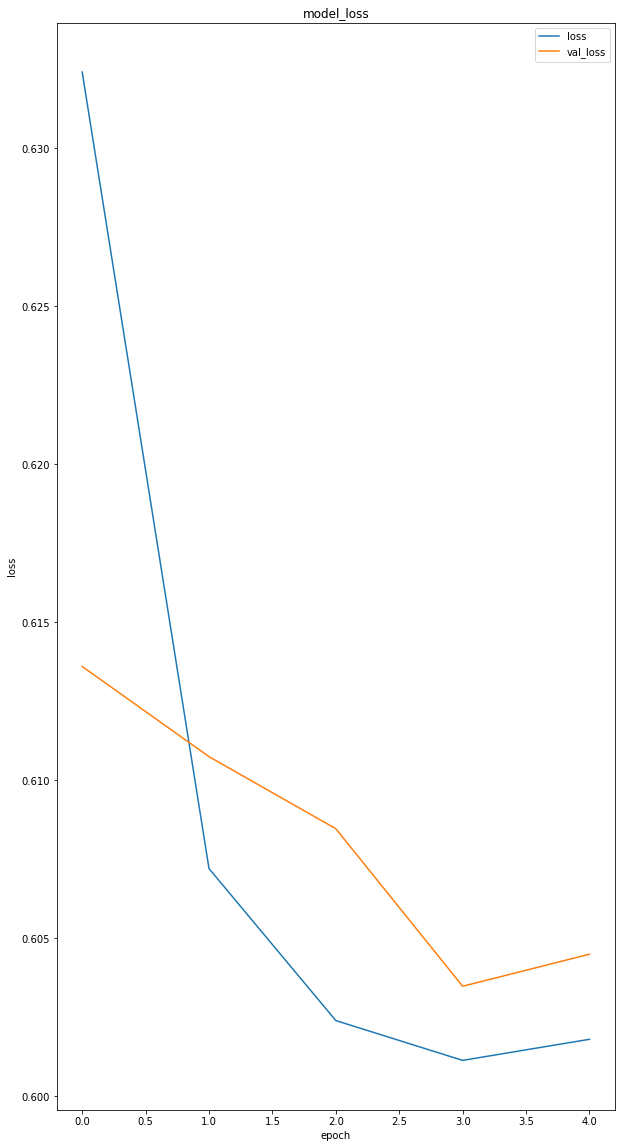

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend() 

#### Find Not Rated movies by each user

In [ ]:
ratings = pd.read_csv('/content/drive/MyDrive/ML/Dataset/ratings_small.csv')
matrix = ratings.pivot(index='movieId', columns='userId', values='rating')

not_rated = np.where(matrix[user_id].isna())
not_watched = not_rated[0] + 1

#### Fit Our Model & Predict Not rated movies 


In [ ]:
movie_df = movies 

movies_watched_by_user = df[df.userId == user_id]

movies_not_watched = not_watched

movies_not_watched = list(set(movies_not_watched).intersection(set(movie2movie_encoded.keys())))

movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]


user_encoder = user2user_encoded.get(user_id)

user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)

ratings = model.predict(user_movie_array).flatten()

176/176 [==============================] - 0s 1ms/step


#### Get top 10 Movies to Recommend

In [ ]:
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

### Show Results

In [ ]:
print("Showing recommendations for user: {}".format(user_id))
print("====" * 10)
print()
print("Movies with high ratings from user:")

top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)

for id in top_movies_user:
  if(movies.loc[movies.id == str(id)].shape[0] != 0):
    title = movies.loc[movies['id'] == str(id)].title.to_string()
    #genre = movies.loc[movies['id'] == str(id)].genres.name
    print(title)

print("----" * 10)
print()
print("Top movie recommendations:")


for id in recommended_movie_ids:
  if(movies.loc[movies.id == str(id)].shape[0] != 0):
    title = movies.loc[movies['id'] == str(id)].title.to_string()
    print(title)


Showing recommendations for user: 1

Movies with high ratings from user:
2591    American Pie
----------------------------------------

Top movie recommendations:
3058    Galaxy Quest
286    Once Were Warriors
7234    Dawn of the Dead
3059    The Talented Mr. Ripley
4020    The Million Dollar Hotel
700    Dead Man
534    Sleepless in Seattle


## Combine All Collaborative operations on a Single function for using in Hybride model

In [ ]:
def CollaborativeRec(ratings, n, userID=user_id):

  # Find Not Rated movies by each user
  matrix = ratings.pivot(index='movieId', columns='userId', values='rating')

  not_rated = np.where(matrix[userID].isna())
  not_watched = not_rated[0] + 1

  # Fit Our Model & Predict Not rated movies for this user
  movie_df = movies 

  movies_watched_by_user = df[df.userId == user_id]

  movies_not_watched = not_watched
  movies_not_watched = list(set(movies_not_watched).intersection(set(movie2movie_encoded.keys())))
  movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]

  user_encoder = user2user_encoded.get(user_id)

  user_movie_array = np.hstack(
      ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
  )

  # Predict ratings by our trained model
  ratings = model.predict(user_movie_array).flatten()

  # Find top 10 movies to recommend
  top_ratings_indices = ratings.argsort()[-3*n:][::-1]
  recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
  ]

  top_movies_user = (
      movies_watched_by_user.sort_values(by="rating", ascending=False)
      .head(5)
      .movieId.values
  )
  # Save results to return
  ctr = 0
  top_movies_id_in_movie_metadata = []
  top_movies_id_in_movie_metadata_ids = []
  for id in recommended_movie_ids:
    if (ctr == n):
      break
    if(movies.loc[movies.id == str(id)].shape[0] != 0):
      title = movies.loc[movies['id'] == str(id)].title.to_string()
      ctr += 1
      top_movies_id_in_movie_metadata.append(movies.loc[movies['id'] == str(id)])
      top_movies_id_in_movie_metadata_ids.append(id)

  #return top_movies_id_in_movie_metadata
  return top_movies_id_in_movie_metadata_ids


# Hybride Recommender System

In [ ]:
ratings = pd.read_csv('/content/drive/MyDrive/ML/Dataset/ratings_small.csv')

In [ ]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

In [ ]:
def ensemble(ratings, movies__, user_Id, n, m):

    # get top n movies we recommed to user by collaborative filtering
    collaborativeModel_Results = CollaborativeRec(ratings, n, user_Id)

    # get top m * n movies we recommed to user by content based filtering
    contentbased_Results = EnsembledCbRec(ratings, movies__, n, m, user_id)

    # aggregate all results to show top n movies to the user
    # we have n movies recommended by collab & m * n movies recommended by content based, we can get intersections of them first

    intersections = intersection(collaborativeModel_Results, contentbased_Results)

    if(len(intersections) == n):
      return intersections

    else:  # we should choose our remaining recommends between other top movies
      remain = n - len(intersections)

      only_colab = list(set(collaborativeModel_Results) - set(intersections))
      only_content = list(set(contentbased_Results) - set(intersections))

      colab_rec_size = int(remain * 0.6)
      content_rec_size = remain - colab_rec_size

      # Now get top movies of colab and content by our metric
      only_colab = only_colab[0:colab_rec_size]
      only_content = only_content[0:content_rec_size]
      all_remains_rec = only_colab + only_content

      #all_remains_rec_str = [str(x) for x in all_remains_rec]
      #all_remains_rec_movies = movies[movies['id'].isin(all_remains_rec_str)]
      #contentbased_Results = EnsembledCbRec(ratings, all_remains_rec_movies, remain, 1, user_id)


      return intersections +  all_remains_rec


### Test collaborativeModel func

In [ ]:
collaborativeModel_Results = CollaborativeRec(ratings, 10, user_id)
collaborativeModel_Results 

176/176 [==============================] - 0s 2ms/step


[926, 527, 923, 1213, 318, 922, 858, 919, 950, 920]

### Test Content Based Func

In [ ]:
contentbased_Results = EnsembledCbRec(ratings, movies1, 10, 5, user_id)
contentbased_Results

[1367,
 1374,
 1246,
 1366,
 1375,
 7555,
 10805,
 27578,
 47104,
 312221,
 2770,
 8273,
 39451,
 302688,
 37047,
 21461,
 42354,
 35688,
 5064,
 43096]

### Test Ensemble Func

In [ ]:
recommended_movie_ids = ensemble(ratings, movies1, user_id, 10, 5)

recommended_movie_ids

176/176 [==============================] - 1s 4ms/step


[527, 858, 926, 950, 919, 920, 47104, 7555, 5064, 8273]

In [ ]:
def print_results(ratings, movies___, user_id, n, m):

  recommended_movie_ids = ensemble(ratings, movies___, user_id, 10, 5)
  recommended_movie_ids_str = [str(x) for x in recommended_movie_ids]
  recommended_movies = movies[movies['id'].isin(recommended_movie_ids_str)]

  print(recommended_movies.title)

In [ ]:
print_results(ratings, movies1, user_id, 10, 5)

176/176 [==============================] - 0s 3ms/step
286           Once Were Warriors
534         Sleepless in Seattle
3058                Galaxy Quest
6437            American Wedding
9284     Blood: The Last Vampire
10826      Ice Age: The Meltdown
10979                       Cars
12356                      Rambo
13875    Through the Olive Trees
30636            Carry On Doctor
Name: title, dtype: object
